In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
43729,I'm really in a bind.,Je suis vraiment dans le pétrin.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
162794,I'd like to discuss this with your boss.,J'aimerais en discuter avec ton patron.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
75321,Tom is reprimanding Mary.,Tom réprimande Marie.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
20153,Please be honest.,Veuillez être honnêtes !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
178246,They caught him playing a trick on his sister.,Ils le prirent en train de faire une farce à s...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 3만3천개 샘플 사용
lines.sample(5)

,eng,fra
25084,It was disgusting.,C'était répugnant.
26400,This is expensive.,C'est cher.
20670,They all drowned.,Ils se sont tous noyés.
24734,I'm being patient.,Je fais montre de patience.
12921,You're in love.,Tu es amoureuse.


# Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '"'
eos_token = '\''
lines.fra = lines.fra.apply(lambda x : '" '+ x + ' \'')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
2280,Keep still.,""" Restez tranquille ! '"
12055,Throw the dice.,""" Jetez le dé. '"
7742,I'm a soldier.,""" Je suis soldat. '"
5892,That's a lot!,""" C'est beaucoup ! '"
9326,What's inside?,""" Qu'est-ce qu'il y a à l'intérieur ? '"


# Step 1. 정제, 정규화, 전처리

In [5]:
for i in range(len(lines.eng)):
    lines.eng[i] = lines.eng[i].lower()
    lines.eng[i] = re.sub(r"([?.!,¿])", r" \1", lines.eng[i]).split()
    lines.eng[i].insert(0, '"')

In [6]:
lines.eng.sample(5)

18810      [", i, know, this, song, .]
32554    [", tom, has, been, fired, .]
21867        [", what's, happening, ?]
22638      [", are, you, listening, ?]
9201            [", we're, certain, .]
Name: eng, dtype: object

In [7]:
for i in range(len(lines.fra)):
    lines.fra[i] = lines.fra[i].lower()
    lines.fra[i] = re.sub(r"([?.!,¿])", r" \1", lines.fra[i]).split()

In [8]:
lines.fra.sample(5)

4835                              [", je, le, crois, ., ']
11828                          [", c'est, mon, idée, ., ']
27544                      [", où, est, mon, billet, ?, ']
20817    [", elles, sont, en, train, de, gagner, du, te...
2079                        [", j'ai, été, dernière, ., ']
Name: fra, dtype: object

# Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [9]:
eng_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[1, 26, 2], [1, 26, 2], [1, 26, 2]]

In [10]:
lines.sample(5)

,eng,fra
13861,"["", how, did, it, feel, ?]","["", qu'avez-vous, ressenti, ?, ']"
26348,"["", they're, surprised, .]","["", ils, sont, étonnés, ., ']"
23646,"["", i, appreciate, this, .]","["", je, l'apprécie, ., ']"
26936,"["", tom, wants, to, play, .]","["", tom, veut, jouer, ., ']"
28485,"["", come, back, in, a, day, .]","["", revenez, demain, !, ']"


In [11]:
fra_tokenizer = Tokenizer(char_level=True)   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 62, 7, 2], [1, 346, 3, 2], [1, 25, 504, 7, 2]]

In [12]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4813
프랑스어 단어장의 크기 : 9984


In [13]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15


In [14]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4813
프랑스어 단어장의 크기 : 9984
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15


In [15]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ word for word in line if word != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ word for word in line if word != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [16]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 62, 7], [1, 346, 3], [1, 25, 504, 7]]
[[62, 7, 2], [346, 3, 2], [25, 504, 7, 2]]


In [17]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [18]:
print(encoder_input[0])

[ 1 26  2  0  0  0  0  0]


In [19]:
#encoder_input = to_categorical(encoder_input)
#decoder_input = to_categorical(decoder_input)
#decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [20]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 15)


# Step 4. 임베딩 층(Embedding layer) 사용하기

In [34]:
from tensorflow.keras.layers import Input, Embedding, Masking, LSTM, Dense
from tensorflow.keras.models import Model

embedding_size = 512
hidden_size = 512

# 인코더 LSTM 셀의 마지막 time step의 hidden state와 cell state를 
# 디코더 LSTM의 첫 번째 hidden state와 cell state로 전달해준다.

# 입력 텐서 생성
encoder_inputs = Input(shape=(None, ))

# 임베딩층 사용
enc_emb =  Embedding(eng_vocab_size, embedding_size)(encoder_inputs)

# 마스킹 사용
enc_masking = Masking(mask_value=0.0)(enc_emb)

# hidden size가 512인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)

# 디코더로 전달할 hidden state, cell state를 리턴, encoder_outputs는 사용하지 않음.
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장
encoder_states = [state_h, state_c]

In [35]:
# 디코더 입력 텐서 생성
decoder_inputs = Input(shape=(None, ))

# 디코더 임베딩 층 사용
dec_emb =  Embedding(fra_vocab_size, hidden_size)(decoder_inputs)

# 디코더 마스킹 사용
dec_masking = Masking(mask_value=0.0)(dec_emb)

# hidden size가 512인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)
# initial_state는 LSTM 셀의 초기 상태를 정의하는 인자이다.

# Step 5. 모델 구현하기

In [36]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')  # 덴스는 단어장 크기로 지정
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [37]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 512)    2464256     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 512)    5111808     input_7[0][0]                    
____________________________________________________________________________________________

In [38]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 128, epochs = 50)

Epoch 1/50
235/235 [==============================] - 18s 48ms/step - loss: 1.7249 - val_loss: 1.6626
Epoch 2/50
235/235 [==============================] - 9s 40ms/step - loss: 1.2029 - val_loss: 1.4475
Epoch 3/50
235/235 [==============================] - 9s 40ms/step - loss: 1.0416 - val_loss: 1.3523
Epoch 4/50
235/235 [==============================] - 10s 41ms/step - loss: 0.9388 - val_loss: 1.2689
Epoch 5/50
235/235 [==============================] - 10s 41ms/step - loss: 0.8600 - val_loss: 1.2313
Epoch 6/50
235/235 [==============================] - 10s 42ms/step - loss: 0.7964 - val_loss: 1.1869
Epoch 7/50
235/235 [==============================] - 10s 42ms/step - loss: 0.7417 - val_loss: 1.1658
Epoch 8/50
235/235 [==============================] - 10s 42ms/step - loss: 0.6935 - val_loss: 1.1448
Epoch 9/50
235/235 [==============================] - 10s 42ms/step - loss: 0.6515 - val_loss: 1.1304
Epoch 10/50
235/235 [==============================] - 10s 42ms/step - loss: 0.6139 

In [39]:
history_dict=history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


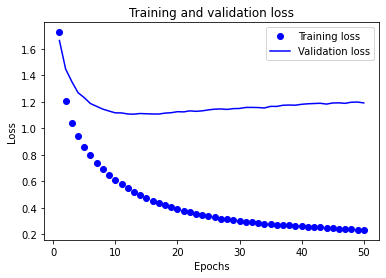

In [40]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(val_loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [41]:
# 인코더 설계시 생성했던 encoder_inputs(=입력 텐서)(encoder_inputs = Input(shape=(None, eng_vocab_size)))와
# hidden state와 cell state를 다음 time step으로 전달하기 위해 별도 저장했던 encoder_states(encoder_states = [state_h, state_c])를 재사용한다.

encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 512)         2464256   
_________________________________________________________________
masking (Masking)            (None, None, 512)         0         
_________________________________________________________________
lstm_5 (LSTM)                [(None, 512), (None, 512) 2099200   
Total params: 4,563,456
Trainable params: 4,563,456
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))

# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size,))

# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
dec_emb_test =  Embedding(fra_vocab_size, hidden_size)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)

# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states = [state_h, state_c]

In [43]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs = [decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 512)    5111808     input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

# Step 6. 모델 평가하기

In [44]:
# 먼저 만들어 두었던 사전을 간단한 변수로 다시 정의
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [50]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra2idx['"']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '\'' or
        len(decoded_sentence) > max_fra_seq_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [51]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx['"'] and encoded_word != fra2idx['\'']):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

In [52]:
# 입력 문장의 인덱스
for seq_index in [111, 222, 333, 444, 555]:
  input_seq = encoder_input[seq_index: seq_index+1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : " i left . 
정답문장 : je suis partie . 
번역문장 : j'y suis . 
--------------------------------------------------
입력문장 : " come on . 
정답문장 : venez ! 
번역문장 : venez ! ! 
--------------------------------------------------
입력문장 : " i stood . 
정답문장 : je me suis tenue debout . 
번역문장 : je me les 
--------------------------------------------------
입력문장 : " you run . 
정답문장 : tu cours . 
번역문장 : tu . . . . 
--------------------------------------------------
입력문장 : " go ahead ! 
정답문장 : avance ! 
번역문장 : en . ! ! ! 
--------------------------------------------------
